# Environment 2

## Policy Gradient algorithms


## Introduction

In this notebook, the goal of this environment is to implement 4 policy gradient algorithms: the regular policy gradient (REINFORCE), the policy gradient with a baseline subtracted (REINFORCE with baseline), the one-step actor-critic method, and the advantage actor-critic method.
Our agent will play a game in continuous state space, for which we will use a basis function representation to limit ourselves to a finite amount of parameters.

Let's start with a few imports:


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from environments.environment2 import *

import matplotlib
import matplotlib.cm
import matplotlib.colors
import numpy as np
import random
from tqdm import tqdm
from scipy.special import *

# reasonable plot size
plt.rcParams['figure.dpi'] = 100

### The environment

The environment is a 2D grid, with a goal in the center, and a "U"-shaped barrier. Our goal is to learn how to reach the objective in the center regardless of where we start. In particular, we will study how the agent learns to go around the barrier when starting at the bottom of the grid.

- The grid is 10x10, going from $(-5, -5)$ to $(5, 5)$.
- The objective is a circle of radius $0.5$ centered at $(0, 0)$, that must be reached for the agent to win.
- The barrier is a "U"-shaped wall of width $1$ centered at $(0, 0)$.
- The agent is not allowed to exit the grid, or enter the wall.

Here is what the grid looks like:
(the objective is in green, the walls are in red).


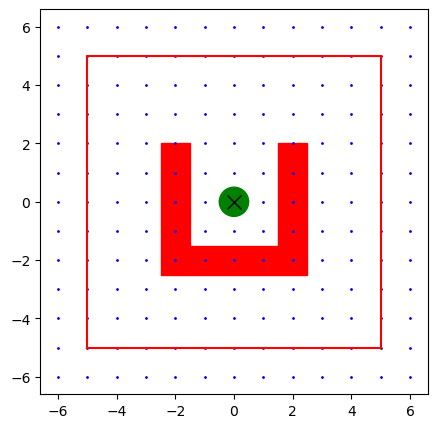

In [3]:
env = UMaze()
env.render()

### Action and reward modeling

We assume that the state space is continuous, i.e. that the agent can be at any allowed position in the grid. At each position, we can move a fixed distance $0.2$ horizontally, vertically, or diagonally. Hence, there are $8$ possible actions:

- Action $0$: move by $0.2 \cdot (0, 1)$.
- Action $1$: move by $0.2 \cdot (\sqrt{2}/2, \sqrt{2}/2)$.
- Action $2$: move by $0.2 \cdot (1, 0)$.
- Action $3$: move by $0.2 \cdot (\sqrt{2}/2, -\sqrt{2}/2)$.
- Action $4$: move by $0.2 \cdot (0, -1)$.
- Action $5$: move by $0.2 \cdot (-\sqrt{2}/2, -\sqrt{2}/2)$.
- Action $6$: move by $0.2 \cdot (-1, 0)$.
- Action $7$: move by $0.2 \cdot (-\sqrt{2}/2, \sqrt{2}/2)$.

We grant a reward of $1$ when the agent reaches the objective. Actions that would cause the agent to hit a wall are ignored.

_Note: the agent is not penalized when it makes a wrong move, otherwise it might become scared of walls and get stuck below the U._


### Policy and value functions

To model our policy function for the continous state space, we first need to give each state and each action a value. For that, we will use a grid of $N$ gaussian basis functions with a fixed standard deviation $\sigma$. **We will study how these two parameters influence the speed and quality of learning.**

Let's define the action value function $q(\vec s, a)$ as follows:
$$q(\vec s, a) = \sum_{i=1}^N w_{i,a} \exp \left(- \frac{||\vec s - \vec x_i||^2}{2\sigma^2}\right)$$
where $\vec x_i$ denotes the position of the $i$-th basis function.
For our policy function $\pi$, we will use a softmax policy:
$$\pi(\vec s, a) = \frac{\exp {q(\vec s, a)}}{\sum_{b=0}^7 \exp {q(\vec s, b)}}.$$
Our goal is to learn the $N \times 8$ weights $w_{i, a}$.

For some algorithms, we will also need to learn a state value function $v(\vec s)$. Once again, we will use basis functions:
$$v(\vec s) = \sum_{i=1}^N \theta_{i} \exp \left(- \frac{||\vec s - \vec x_i||^2}{2\sigma^2}\right).$$
For the value function, there are $N$ parameters to learn: the weights $\theta_i$.


### Policy gradient (REINFORCE)

The standard policy gradient only uses the policy function and the gradient of the log-policy $\nabla_{w} \ln \pi(\vec s, a)$. Here is the pseudocode:

![Reinforce](assets/Reinforce.png)


### Policy gradient with baseline subtracted (REINFORCE with baseline)

We can subtract a baseline in the policy gradient algorithm. As seen in the lecture, that should improve the speed of learning. We will use the value function as the baseline, and we will also need its gradient to update it.

![ReinforceWithBaseline](assets/ReinforceWithBaseline.png)


### One-step actor-critic

In the previous two algorithms, we can only perform the update at the end of the episode. The disadvantages are that we need to wait longer before we can learn, and we also use more memory to store all the past states, actions and rewards. With the one-step actor-critic algorithm, the updates are instead performed in real time.

![OneStepActorCritic](assets/OneStepActorCritic.png)


### Actor-critic with eligibility traces

We also look at the eligibility trace version of the actor-critic algorithm, also known as Advantage Actor-Critic.

![EligibilityTraceActorCritic](assets/EligibilityTraceActorCritic.png)


## Implementation

Your goal is to implement the algorithms explained above, and observe the following:

- How the number of basis functions influences the speed of learning.
- How the standard deviation of the basis functions influences the speed of learning.
- How the choice of algorithm influences the speed of learning.

Here are a few important notes:

- In each episode, we pick the starting position at random.
- The discount factor $\gamma$ needs to be very close to $1$ due to the high number of steps per episode. $0.99$ is a good choice.
- To avoid wasting too much time in the early episodes, we enforce a hard limit on the number of steps per episode. $300$ is a good limit.


### Core model functions

Here are a few core functions that we will use in all 3 algorithms. The `ModelParams` class is used to store the discount factor $\gamma$, the count and shape of the basis functions, and the weights $w_{i,a}$ and $\theta_i$. Please complete the code as necessary.


$$q(\vec s, a) = \sum_{i=1}^N w_{i,a} \exp \left(- \frac{||\vec s - \vec x_i||^2}{2\sigma^2}\right)$$
$$\pi(\vec s, a) = \frac{\exp {q(\vec s, a)}}{\sum_{b=0}^7 \exp {q(\vec s, b)}} \rightarrow \nabla_w \ln(\pi(s,a)) = \exp \left(- \frac{||\vec s - \vec x_i||^2}{2\sigma^2}\right) (1 - \pi(\vec s, a))$$
$$v(\vec s) = \sum_{i=1}^N \theta_{i} \exp \left(- \frac{||\vec s - \vec x_i||^2}{2\sigma^2}\right) \rightarrow \nabla_\theta v(s) = \exp \left(- \frac{||\vec s - \vec x_i||^2}{2\sigma^2}\right)$$


In [3]:
class ModelParams:
    def __init__(self, npoints=13, gamma=0.99, stdev=0.5):
        self.action_weights = np.zeros((npoints * npoints, 8))
        self.value_weights = np.zeros(npoints * npoints)
        # need to be VERY careful here given the large number of iterations
        # if gamma is too small we'll have a hard time updating the policy correctly!
        self.gamma = gamma
        self.stdev = stdev

        self.npoints = npoints
        positions = np.linspace(-6, 6, npoints)  
        x_pos, y_pos = np.meshgrid(positions, positions)
        self.x_pos = x_pos.flatten()
        self.y_pos = y_pos.flatten()

        self.w_cache = None
        self.w_cache_pos = None

    def get_interpolation_weights(self, position: State) -> np.ndarray:
        """
        This returns an array of size N, weight for each i: exp(-||s-x_i||^2/(2\sigma^2)) 
        position: a list of two values: first for x pos; second for y pos
        """
        # We do a bit of caching to not compute this every time
        if self.w_cache_pos == position:
            return self.w_cache

        w = np.exp(- ((self.x_pos - position[0]) ** 2 + (self.y_pos - position[1]) ** 2) / (2 * self.stdev ** 2))
        self.w_cache = w
        self.w_cache_pos = position
        return w

    def compute_value(self, position: State) -> float:
        """
        This computes the v(s) function.
        """
        
        # TO COMPLETE: multiply interpolation weights with self.value_weights
        return self.get_interpolation_weights(position) @ self.value_weights

    def get_action_values(self, position: State) -> np.ndarray:
        """
        This computes [q(s,a) for all a] for a specific s.
        """
        
        # TO COMPLETE: multiply interpolation weights with action weights
        i_w = self.get_interpolation_weights(position)
        return [i_w @ a_w for a_w in  self.action_weights.T]

    def get_action_probabilities(self, position: State) -> np.ndarray:
        """
        This computes the [\pi(s, a) for all a].
        """
        
        # TO COMPLETE: compute the softmax
        action_values = self.get_action_values(position)
        return softmax(action_values)

    def get_action_probability(self, position: State, action: Action) -> float:
        """
        This computes \pi(s, a).
        action: an int of [0,7]
        """
        return self.get_action_probabilities(position)[action]

    def pick_action(self, position: State) -> Action:
        """
        This randomly chooses an action following the policy.
        """
        probs = self.get_action_probabilities(position)
        # np.random.choice is a bit slow, so we code it by hand
        r = random.random()
        for i, p in enumerate(probs):
            r -= p
            if r < 0:
                return i

    def compute_action_log_grad(self, position: State, action: Action) -> np.ndarray:
        """
        This computes \nabla_w \ln(\pi(s,a))
        """

        # TO COMPLETE: compute the gradient
        exp = self.get_interpolation_weights(position)
        pi = self.get_action_probabilities(position)
        action_log_grads = np.zeros_like(self.action_weights)
        action_log_grads = np.outer(exp, (-pi))
        action_log_grads[:,action] += exp

        return action_log_grads

    def compute_value_grad(self, position: State) -> np.ndarray:
        """
        This computes \nabla_\theta v(s).
        """
        
        # TO COMPLETE: compute the gradient
        return self.get_interpolation_weights(position)

def find_starting_pos(env: UMaze) -> State:
    """
    This picks a random starting position inside the bounds of the environment.
    """
    pos_candidate = None
    while pos_candidate is None:
        pos_candidate = (random.uniform(-5, 5), random.uniform(-5, 5))
        # the two below are easier, and can be used for debugging
#         pos_candidate = (0, 4)
#         pos_candidate = (random.uniform(-1.5, 1.5), random.uniform(-1.5, 1.5))
        if env.is_outside_of_area(*pos_candidate) or env.is_in_objective(*pos_candidate):
            pos_candidate = None
    return pos_candidate

### Plots and helpers

Here are a few functions to provide nice visualization for the learned value and policy functions.


In [4]:
def render_values(params: ModelParams):
    """
    Visualises the v(s) function for all possible states.
    """
    xs = np.linspace(-6, 6, 101)
    ys = np.linspace(-6, 6, 101)
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    values = np.zeros_like(X)
    for i in range(101):
        for j in range(101):
            values[i, j] = params.compute_value((xs[i], ys[j]))
    cs = plt.contourf(X, Y, values, levels=10, cmap="jet")
    plt.xlabel("x")
    plt.ylabel("y")
    cbar = plt.colorbar(cs)
    cbar.set_label("Value")
    plt.title("Computed values")

def render_actions(params: ModelParams):
    """
    This visualises the most probable action in each state using a colored arrow. 
    Color of the arrow indicates probability.
    Only shows a few discrete points.
    """
    colormap = matplotlib.cm.get_cmap("jet")

    xs = np.linspace(-5, 5, 21)
    ys = np.linspace(-5, 5, 21)
    for x in xs:
        for y in ys:
            action_probabilities = params.get_action_probabilities((x, y))
            action = np.argmax(action_probabilities)
            max_probability = action_probabilities[action]
            plt.plot(x, y, "o", color="black", markersize=0.1)
            plt.arrow(x, y, 0.3 * MOVES[action][0], 0.3 * MOVES[action][1], head_width=0.1, head_length=0.1, color=colormap(max_probability), linewidth=1)

    plt.xlabel("x")
    plt.ylabel("y")
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))
    cbar.set_label("Probability")
    plt.title("Preferred actions")

Here is a function that you can use to run a learning algorithm, and display a nice visualization of the results.


In [5]:
from IPython.display import Markdown

def run_algorithm(env: UMaze, params: ModelParams, algorithm, plot_values, num_episodes: int, bucket_size: int = 500, **kwargs):
    """
    This function runs an algorithm for a specified number of episodes.
    Its arguments are:
    * env(UMaze): Instance of the environment
    * params(ModelParam): Parameters given to the model.
    * algorithm(function that accepts env and params as arguments and returns a Tuple[float, int]): Your algorithm.
    * plot_values(bool): If True, it will plot the values using one of the helper functions above.
    * num_episodes(int): Number of episodes to play.
    * bucket_size(int): Specifies how big groups should be when computing averages, i.e. a size of 500 averages a reward for diplay over 500 episodes.
    * Extra arguments specified like "action_rate=0.1" will be passed to the algorithm
    """
    assert num_episodes % bucket_size == 0, "num_episodes must be a multiple of bucket_size"

    num_buckets = num_episodes // bucket_size
    rewards = np.zeros(num_buckets)
    lengths = np.zeros(num_buckets)
    for i in tqdm(range(num_episodes)):
        random.seed(i) # set the seed to the episode id to ensure reproducibility
        episode_reward, episode_length = algorithm(env, params, **kwargs)
        rewards[i // bucket_size] += episode_reward / bucket_size
        lengths[i // bucket_size] += episode_length / bucket_size
    plot_points = (np.arange(num_buckets) + 1) * bucket_size

    display(Markdown("#### %s (sigma=%.2f, npoints=%d^2)" % (algorithm.__name__, params.stdev, params.npoints)))
    plt.subplot(221)
    plt.plot(plot_points, rewards)
    plt.title("Fraction of episodes where the goal is reached before %d iterations" % 300) # Max iterations is hardcoded to 300 by default
    plt.xlabel("Episode")
    plt.ylabel("Fraction")

    plt.subplot(222)
    plt.plot(plot_points, lengths)
    plt.title("Episode length over time")
    plt.xlabel("Episode")
    plt.ylabel("Episode length")

    plt.subplot(223)
    render_actions(params)

    if plot_values:
        plt.subplot(224)
        render_values(params)

    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    #plt.tight_layout()
    plt.gcf().set_size_inches(12, 8)
    plt.show()

### REINFORCE

First, implement the reinforce algorithm:


In [6]:
def reinforce(env: UMaze, params: ModelParams, action_rate = 5e-2, max_iter = 300) -> Tuple[float, int]:
    """
    Run an episode and mutate the params in-place.
    :return: tuple containing the (total) reward for the episode, and the number of steps
    """
    env.reset()
    # Pick random starting position
    env._state = find_starting_pos(env)
    states = [env._state]
    actions = []
    rewards = []
    iteration = 0
    while iteration < max_iter and not env.end:
        # Compute action
        action = params.pick_action(states[-1])
        actions.append(action)
        # Do action
        state, reward = env.do_action(action)
        states.append(state)
        rewards.append(reward)
        iteration += 1
    
    rewards = np.array(rewards)
    for t in range(len(actions)):
        # TO COMPLETE: compute G
        G = sum(params.gamma**(k - t) * rewards[k] for k in range(t, len(rewards)))
        # TO COMPLETE: update action weights -> ??? DO WE NOT SPECIFY THE ACTION ???
        params.action_weights += action_rate * params.gamma**t * G * params.compute_action_log_grad(position=states[t], action=actions[t])
        
    return sum(rewards), iteration

Now, you can perform a few experiments!


100%|██████████| 10000/10000 [52:51<00:00,  3.15it/s] 


#### reinforce (sigma=0.25, npoints=9^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_4008\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_4008\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


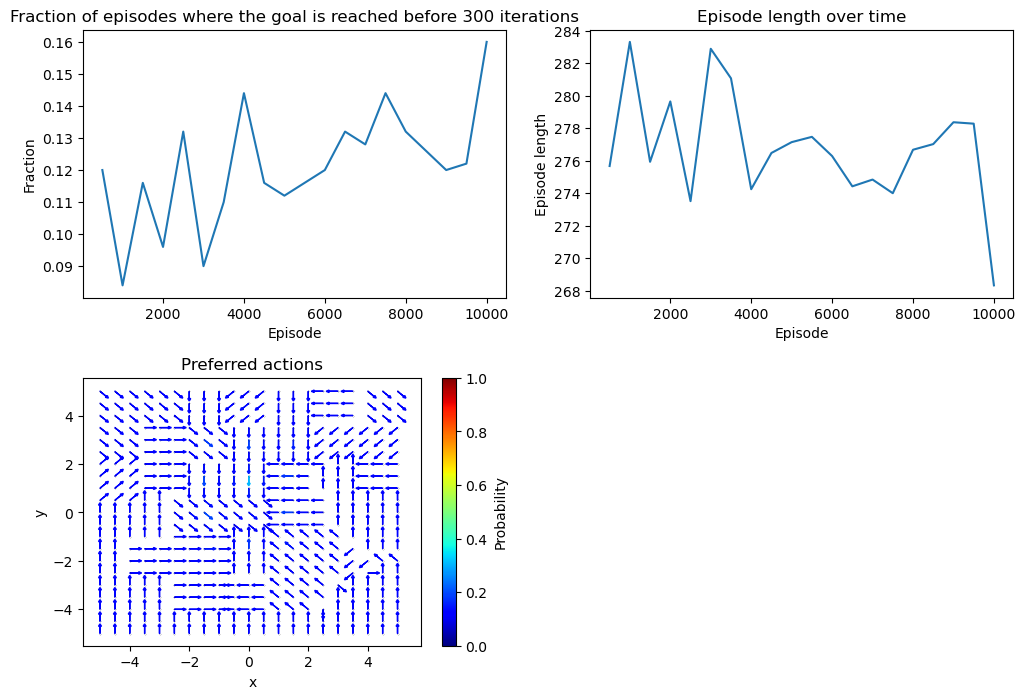

In [10]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=9), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=9), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=9), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=9), reinforce, plot_values=False, num_episodes=10000)

100%|██████████| 10000/10000 [05:34<00:00, 29.89it/s]


#### reinforce (sigma=1.50, npoints=9^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


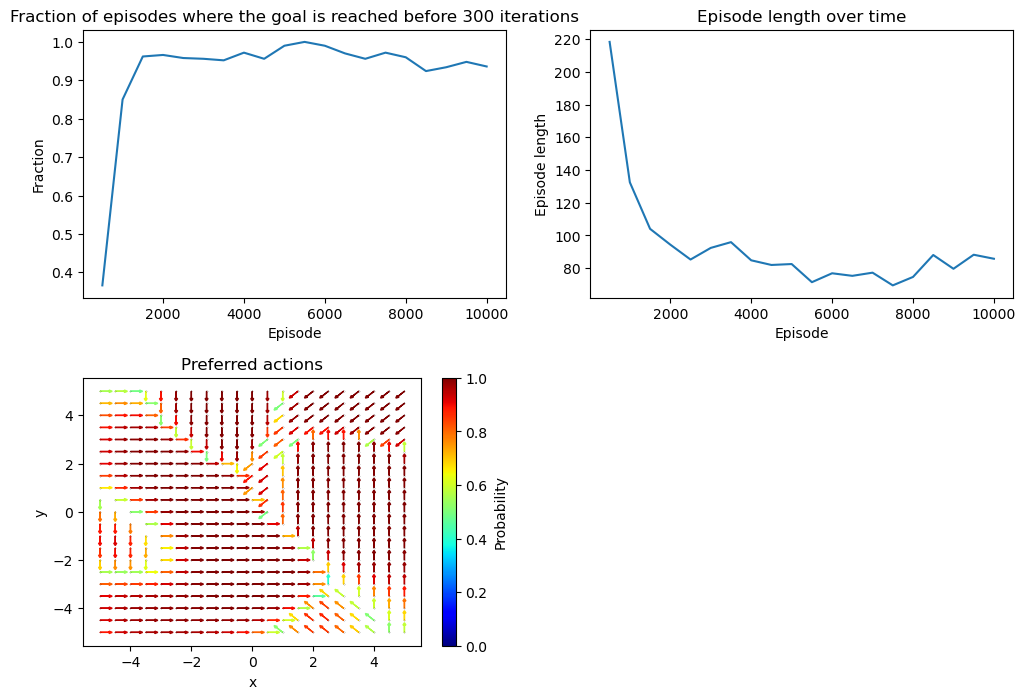

In [9]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=9), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=13), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=13), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=13), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=13), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.15, npoints=19), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=19), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=19), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=19), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=19), reinforce, plot_values=False, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=19), reinforce, plot_values=False, num_episodes=10000)

### REINFORCE with baseline

Now, copy/paste and modify your `reinforce` function above to subtract a basline.


In [11]:
def reinforce_with_baseline(env: UMaze, params: ModelParams, action_rate = 5e-2, value_rate = 5e-2, max_iter = 300) -> Tuple[float, int]:
    """
    Run an episode and mutate the params in-place.
    :return: tuple containing the (total) reward for the episode, and the number of steps
    """
    
    # TO COMPLETE: copy/paste reinforce() and subtract the baseline. Don't forget to update the value weights.
    env.reset()
    # Pick random starting position
    env._state = find_starting_pos(env)
    states = [env._state]
    actions = []
    rewards = []
    iteration = 0
    while iteration < max_iter and not env.end:
        # Compute action
        action = params.pick_action(states[-1])
        actions.append(action)
        # Do action
        state, reward = env.do_action(action)
        states.append(state)
        rewards.append(reward)
        iteration += 1
    
    rewards = np.array(rewards)
    for t in range(len(actions)):
        # TO COMPLETE: compute G
        G = sum(params.gamma**(k - t) * rewards[k] for k in range(t, len(rewards))) - params.compute_value(position=states[t])
        params.action_weights += action_rate * params.gamma**t * G * params.compute_action_log_grad(position=states[t], action=actions[t])
        params.value_weights += action_rate * params.gamma**t * G * params.compute_value_grad(position=states[t])

    return sum(rewards), iteration


Now, you can perform a few experiments!


In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=9), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=9), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=9), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=9), reinforce_with_baseline, plot_values=True, num_episodes=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [06:40<00:00, 24.95it/s]


#### reinforce_with_baseline (sigma=1.50, npoints=9^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


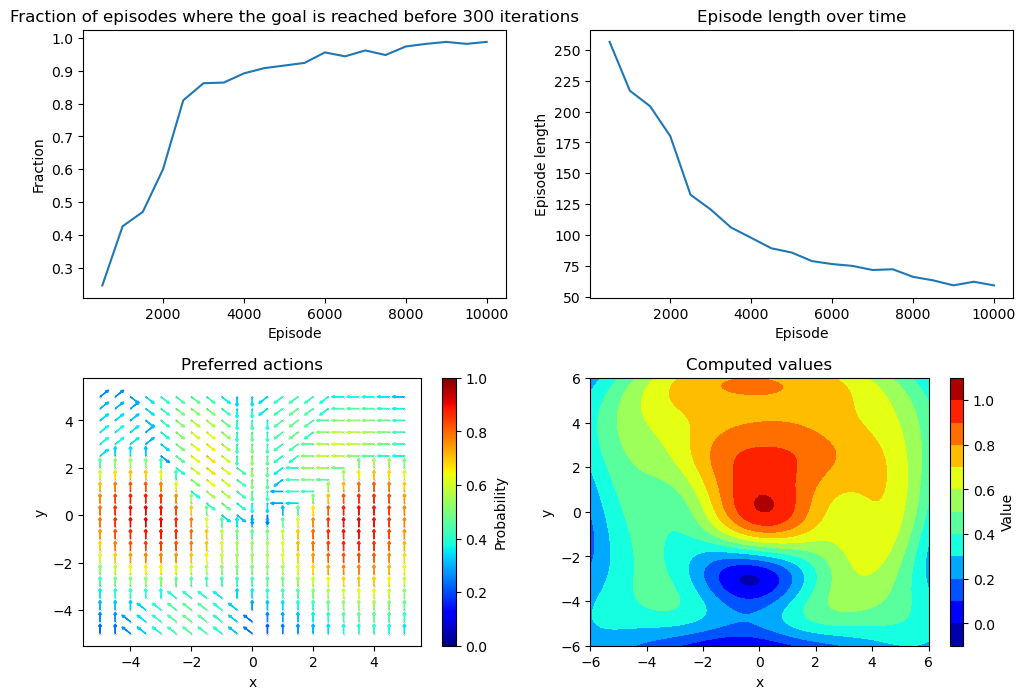

In [14]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=9), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.15, npoints=19), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=19), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=19), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=19), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=19), reinforce_with_baseline, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=19), reinforce_with_baseline, plot_values=True, num_episodes=10000)

### One-step actor-critic

Now, implement the one-step actor-critic algorithm.


In [15]:
def one_step_actor_critic(env: UMaze, params: ModelParams, action_rate = 5e-2, value_rate = 5e-2, max_iter = 300) -> Tuple[float, int]:
    """
    Run an episode and mutate the params in-place.
    :return: tuple containing the (total) reward for the episode, and the number of steps
    """
    env.reset()
    # Pick random starting position
    env._state = find_starting_pos(env)
    total_reward = 0
    iteration = 0
    I = 1
    while iteration < max_iter and not env.end:
        old_state = env._state
        # Compute action
        action = params.pick_action(old_state)
        # Do action
        state, reward = env.do_action(action)
        total_reward += reward
        # Update
        new_value = 0 if env.end else params.compute_value(state)
        old_value = params.compute_value(old_state)
        
        # TO COMPLETE: 
        delta = reward + params.gamma * new_value - old_value
        params.value_weights += value_rate * delta * params.compute_value_grad(position=old_state)
        params.action_weights += action_rate * I * delta * params.compute_action_log_grad(position=old_state, action=action)
                
        I *= params.gamma
        iteration += 1

    return total_reward, iteration

Now, you can perform a few experiments!


100%|██████████| 10000/10000 [06:49<00:00, 24.39it/s]


#### one_step_actor_critic (sigma=0.25, npoints=9^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


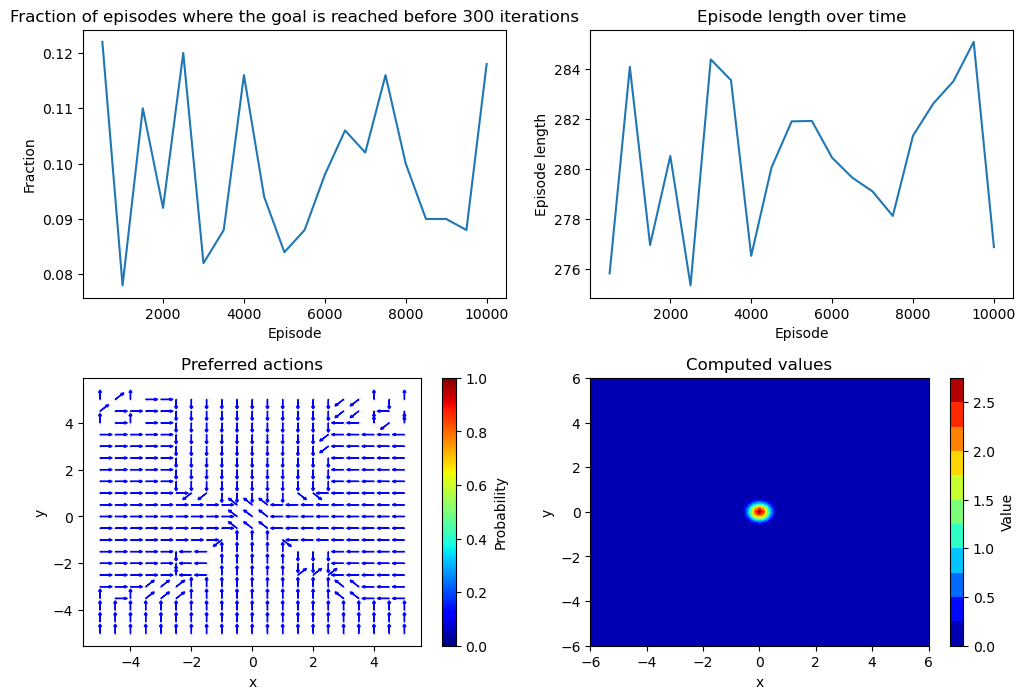

In [17]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=9), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=9), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=9), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=9), one_step_actor_critic, plot_values=True, num_episodes=10000)

100%|██████████| 10000/10000 [01:46<00:00, 93.46it/s] 


#### one_step_actor_critic (sigma=1.50, npoints=9^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


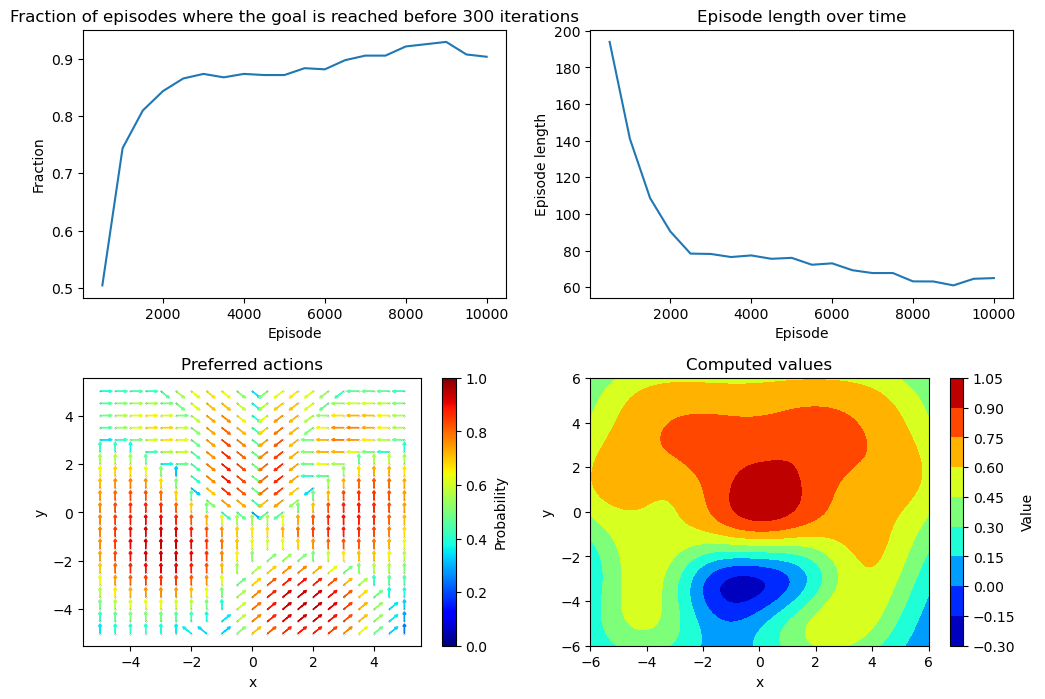

In [16]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=9), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=13), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=13), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=13), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=13), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.15, npoints=19), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=19), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=19), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=19), one_step_actor_critic, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=19), one_step_actor_critic, plot_values=True, num_episodes=10000)

100%|██████████| 10000/10000 [01:51<00:00, 89.67it/s]


#### one_step_actor_critic (sigma=1.50, npoints=19^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


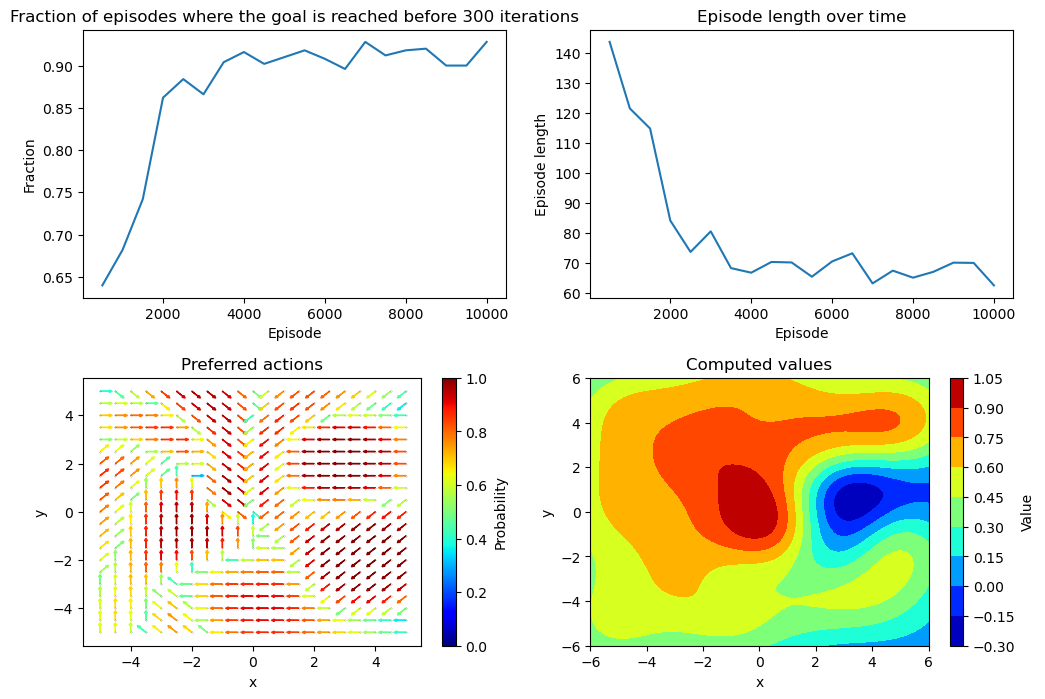

In [18]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=19), one_step_actor_critic, plot_values=True, num_episodes=10000)

### Actor-critic with eligibility traces

Finally, implement the actor-critic algorithm with elgibility traces. Copy/paste and modify your `one_step_actor_critic` function above to use eligibility traces.


In [10]:
def actor_critic_with_eligibility_traces(env: UMaze, params: ModelParams, action_rate = 5e-2, value_rate = 5e-2, max_iter = 300, trace_decay=0.99) -> Tuple[float, int]:
    """
    Run an episode and mutate the params in-place.
    :return: tuple containing the (total) reward for the episode, and the number of steps
    """
    # TO COMPLETE: copy/paste one_step_actor_critic() and add eligibility traces. Notice the additional trace_decay parameter.
    env.reset()
    # Pick random starting position
    env._state = find_starting_pos(env)
    
    total_reward = 0
    iteration = 0
    I = 1
    value_trace = np.zeros_like(params.value_weights)
    action_trace = np.zeros_like(params.action_weights)
    while iteration < max_iter and not env.end:
        old_state = env._state
        # Compute action
        action = params.pick_action(old_state)
        # Do action
        state, reward = env.do_action(action)
        total_reward += reward
        # Update
        new_value = 0 if env.end else params.compute_value(state)
        old_value = params.compute_value(old_state)
        
        # TO COMPLETE: 
        delta = reward + params.gamma * new_value - old_value
        
        value_trace = trace_decay * params.gamma * value_trace +  params.compute_value_grad(position=old_state)
        action_trace = trace_decay * params.gamma * action_trace +  I * params.compute_action_log_grad(position=old_state, action=action)

        params.value_weights += value_rate * delta * value_trace
        params.action_weights += action_rate * delta * action_trace
                
        I *= params.gamma
        iteration += 1

    return total_reward, iteration

Now, you can perform a few experiments!


In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=9), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=9), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=9), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=9), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=9), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=13), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [08:53<00:00, 18.74it/s]


#### actor_critic_with_eligibility_traces (sigma=0.50, npoints=13^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_13296\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_13296\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


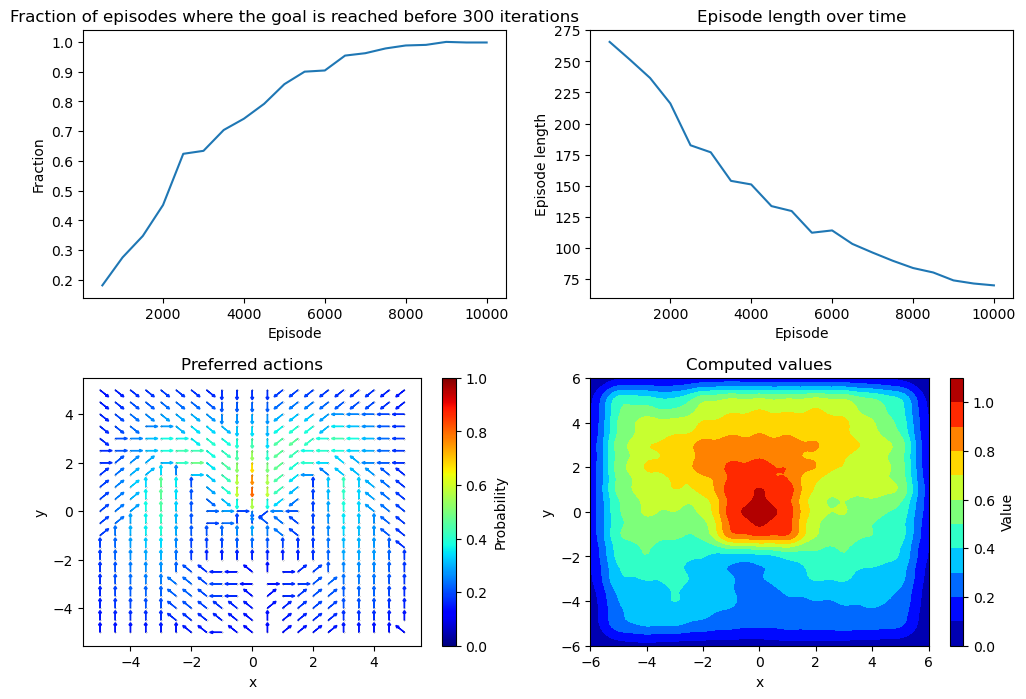

In [11]:
# run this
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=13), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=13), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=13), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.15, npoints=19), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.25, npoints=19), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=19), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=0.75, npoints=19), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.00, npoints=19), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

In [ ]:
run_algorithm(UMaze(), ModelParams(stdev=1.50, npoints=19), actor_critic_with_eligibility_traces, plot_values=True, num_episodes=10000)

## Questions

Make sure you try running with various `npoints` and `stdev` values. Good values for `npoints` are $9$, $13$ and $19$.


### Compare the various algorithms


#### So far, we left the learning rates at their default value of 5e-2. How do REINFORCE and REINFORCE with baseline compare?


**Answer:**

REINFORCE -> As we increase the std, it gets quite unstable </br>
REINFORCE with baseline -> It actually gets better for high std

_Notice: Low std is like discrete, as we increase the std, it gets more smooth, and for a very large std, the results are super unstable (incorrect)_

---


Algorithms with a value function (e.g., REINFORCE with baseline) are expected to be more stable than REINFORCE, and should allow higher learning rate for the action. Experiment with the learning rates of action and see what happens.

You can adjust the learning rates by passing extra arguments to `run_algorithm`, for example:

```py
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000, action_rate=<insert action rate>)
```


#### What happens when you increase the learning rate of action?

Can you explain this?


100%|██████████| 10000/10000 [32:40<00:00,  5.10it/s]


#### reinforce_with_baseline (sigma=0.50, npoints=13^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


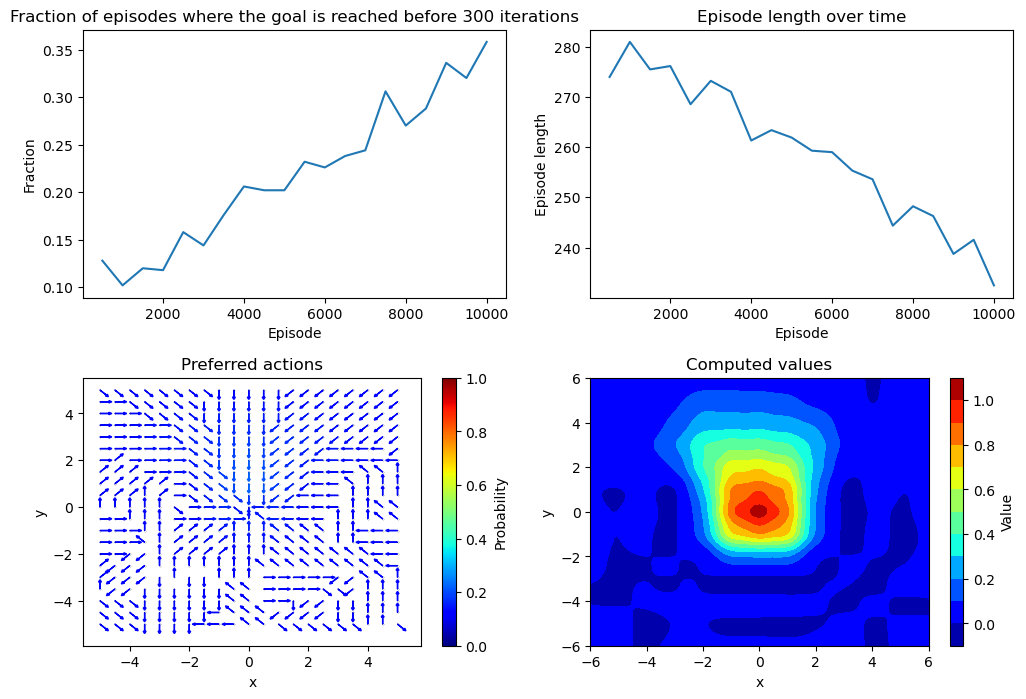

In [20]:
# Lower action rate
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000, action_rate=5e-3)

100%|██████████| 10000/10000 [11:20<00:00, 14.69it/s]


#### reinforce_with_baseline (sigma=0.50, npoints=13^2)

C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap("jet")
C:\Users\jsayd\AppData\Local\Temp\ipykernel_8904\504547451.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap=colormap))


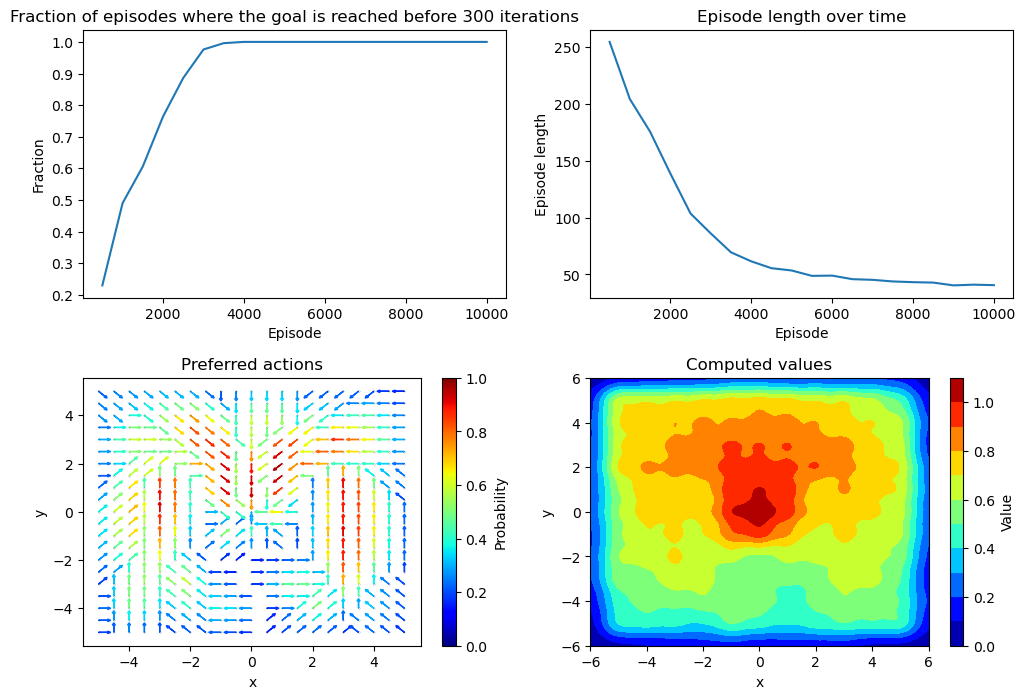

In [21]:
# Higher action rate
run_algorithm(UMaze(), ModelParams(stdev=0.50, npoints=13), reinforce_with_baseline, plot_values=True, num_episodes=10000, action_rate=5e-1)

**Answer:**

It can update the action weights faster with higher action rate, making it learn faster. However with super high action rate, of course, the update get's unstable.

---


#### How do the two actor-critic algorithms compare?


**Answer:**

On-step actor critic seems to be more stable as we increase the std. </br>
Actor critic with eligibility traces learns (spreads) faster even for low std.

---


#### How does REINFORCE with baseline compare to the actor-critic algorithms?


**Answer:**

For low std. REINFORCE with baseline spreads faster.
Actor critic algorithms seem to be more stable

---


### For each value of `npoints`: try running with various standard deviations.


#### What happens when `stdev` is too small?

Can you explain this?


**Answer:**

It does not spread much (it cannot learn fast), because it affects only the local points.

---


#### What happens when `stdev` is too big?

Can you explain this?


**Answer:**

The learning gets unstable. As the std becomes close to the width of the environment, we are unable to capture the local variations, because it affects too many points.

---


#### Does the optimal value of `stdev` depend on `npoints`?

Can you explain this?


**Answer:**

As the npoints increases, the states will get denser, so we would need to decrease the std to capture the local points as well.

---
